## Projeto de Machine Learning - Prevendo Manutenção de Máquinas Industriais

In [1]:
!pip install -q xgboost

In [2]:
# Imports

import pickle
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
%reload_ext watermark
%watermark -a "Marcelo Medeiros | Cientista de Dados"

Author: Marcelo Medeiros | Cientista de Dados



#### Problema de Negócio

Objetivo: Prever se uma máquina industrial precisará ou não de manutenção através de 178 leituras de sensores IoT
(Internet of Things).

In [4]:
# Carregando os dados
df = pd.read_csv("dataset.csv")

In [5]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,VARIAVEL_ALVO
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [6]:
df.shape

(11500, 179)

#### Análise Exploratória e definição da variável Alvo

In [7]:
#Resumo Estatístico
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,VARIAVEL_ALVO
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,...,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,0.200000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,...,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,0.400017
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,...,-1867.000000,-1865.000000,-1642.000000,-1723.000000,-1866.000000,-1863.000000,-1781.000000,-1727.000000,-1829.000000,0.000000
25%,-54.000000,-55.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-55.00000,-55.00000,-54.000000,...,-55.000000,-56.000000,-56.000000,-56.000000,-55.000000,-56.000000,-55.000000,-55.000000,-55.000000,0.000000
50%,-8.000000,-8.000000,-7.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.00000,-7.00000,-7.000000,...,-9.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.000000,-9.000000,-9.000000,-9.000000,0.000000
75%,34.000000,35.000000,36.000000,36.000000,35.000000,36.000000,35.000000,36.00000,36.00000,35.250000,...,34.000000,34.000000,33.000000,33.000000,34.000000,34.000000,34.000000,34.000000,34.000000,0.000000
max,1726.000000,1713.000000,1697.000000,1612.000000,1518.000000,1816.000000,2047.000000,2047.00000,2047.00000,2047.000000,...,1777.000000,1472.000000,1319.000000,1436.000000,1733.000000,1958.000000,2047.000000,2047.000000,1915.000000,1.000000


In [8]:
print("Número de Colunas:", len(df.columns))

Número de Colunas: 179


In [9]:
# Verificando dados Ausentes
df.isna().sum().sum()

0

In [10]:
# Verificando dados Nulos
df.isnull().sum().sum()

0

In [11]:
# Calculando a prevalência da classe positiva (nª de amostras positivas / nª de amostras)
def calc_prevalencia(y_actual):
    return sum(y_actual) / len(y_actual)

In [12]:
print("Prevalência da classe positiva: %.2f"% calc_prevalencia(df['VARIAVEL_ALVO'].values * 100))

Prevalência da classe positiva: 20.00


**Os dados estão desbalanceados (20% das máquinas precisaram de manutenção, enquanto 80% não precisaram).
Precisaremos balancear os dados para treinamento do modelo de ML.**

#### Limpeza dos dados

In [13]:
# Preparando o dataset somente com os dados de interesse
collist = df.columns.tolist()
cols_input = collist[0:178]
df_data = df[cols_input + ['VARIAVEL_ALVO']]

In [14]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,VARIAVEL_ALVO
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [15]:
# Conferindo se temos colunas duplicadas
dup_cols = set([x for x in cols_input if cols_input.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "Há colunas duplicadas"

set()


In [16]:
# Conferindo se temos colunas duplicadas no dataset final
cols_df_data = list(df_data.columns)
dup_cols = set([x for x in cols_df_data if cols_df_data.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "Há colunas duplicadas"

set()


Não temos colunas duplicadas

####  Divisão de dados em treino, teste e validação

In [17]:
df_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,VARIAVEL_ALVO
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [18]:
# Gerando amostras aleatórias dos dados
df_data = df_data.sample(n = len(df_data))

In [19]:
# Ajustando os índices do dataset
df_data = df_data.reset_index(drop=True)

In [20]:
# Gerando um índice para a divisão
df_valid_teste = df_data.sample(frac = 0.3)
print("Tamanho da divisão de validação / teste: %.1f"% (len(df_valid_teste) / len(df_data)))

Tamanho da divisão de validação / teste: 0.3


In [21]:
# Fazendo a divisão 70/15/15

# Teste
df_teste = df_valid_teste.sample(frac=0.5)

# Validação
df_valid = df_valid_teste.drop(df_teste.index)

# Treino
df_treino = df_data.drop(df_valid_teste.index)

In [22]:
# Verifique a prevalência de cada subconjunto
print("Teste(n = %d): %.3f" % (len(df_teste), calc_prevalencia(df_teste.VARIAVEL_ALVO.values)))
print("Validação(n = %d): %.3f" % (len(df_valid), calc_prevalencia(df_valid.VARIAVEL_ALVO.values)))
print("Treino(n = %d): %.3f" % (len(df_treino), calc_prevalencia(df_treino.VARIAVEL_ALVO.values)))

Teste(n = 1725): 0.198
Validação(n = 1725): 0.214
Treino(n = 8050): 0.197


In [23]:
print('Todas as amostras (n = %d)'%len(df_data))
assert len(df_data) == (len(df_teste) + len(df_valid) + len(df_treino)), 'algo saiu errado'

Todas as amostras (n = 11500)


#### Balanceamento de Classe

In [24]:
# Cria um índice
rows_pos = df_treino.VARIAVEL_ALVO == 1

In [25]:
# Define valores positivos e negativos do índice
df_train_pos = df_treino.loc[rows_pos]
df_train_neg = df_treino.loc[~rows_pos]

In [26]:
# Valor mínimo
n = np.min([len(df_train_pos), len(df_train_neg)])

In [27]:
# Obtém valores aleatórios para o dataset de treino
df_treino_final = pd.concat([df_train_pos.sample(n = n, random_state = 64), 
                             df_train_neg.sample(n = n, random_state = 64)], 
                             axis = 0, 
                             ignore_index = True)

In [28]:
# Amostragem
df_treino_final = df_treino_final.sample(n = len(df_treino_final), random_state = 64).reset_index(drop = True)

In [29]:
print('Balanceamento em Treino(n = %d): %.3f'%(len(df_treino_final), 
                                               calc_prevalencia(df_treino_final.VARIAVEL_ALVO.values)))

Balanceamento em Treino(n = 3178): 0.500


**Principais Técnicas de Balanceamento de Classe**

**Undersampling**: Esta técnica envolve reduzir o número de exemplos da classe majoritária para igualar ao número de exemplos da classe minoritária. Ou seja, você diminui o tamanho do conjunto de dados ao remover aleatoriamente registros da classe que tem mais exemplos. Isso pode ajudar a equilibrar o conjunto de dados, mas também pode resultar na perda de informações importantes, pois muitos dados da classe majoritária são descartados.

**Oversampling**: Por outro lado, o oversampling envolve aumentar o número de exemplos na classe minoritária para que se iguale ao número de exemplos na classe majoritária. Isso geralmente é feito replicando os registros da classe minoritária ou gerando dados sintéticos semelhantes. Essa abordagem mantém todas as informações da classe majoritária e aumenta o conjunto de dados, mas pode levar a um problema de overfitting, onde o modelo aprende demais os detalhes específicos da classe minoritária replicada ou pode gerar um dataset tendencioso.

In [30]:
# Salvamos todos os datasets em disco no formato csv.
df_treino.to_csv('dados_treino.csv', index = False)
df_treino_final.to_csv('dados_treino_final.csv', index = False)
df_valid.to_csv('dados_valid.csv', index = False)
df_teste.to_csv('dados_teste.csv', index = False)

In [31]:
# Salvando os dados de entrada
pickle.dump(cols_input, open('cols_input.sav', 'wb'))

Criando as Matrizes X e Y.

In [32]:
# X
X_treino = df_treino_final[cols_input].values
X_valid = df_valid[cols_input].values

In [33]:
# Y
y_treino = df_treino_final['VARIAVEL_ALVO'].values
y_valid = df_valid['VARIAVEL_ALVO'].values

In [34]:
X_treino

array([[ -48,  -89,  -97, ..., -100,  -92, -103],
       [  76,   55,   39, ...,  -56,  -44,  -44],
       [  92,   79,   63, ..., -131, -136, -140],
       ...,
       [-168, -155, -122, ...,   19,   45,   59],
       [-274, -232, -192, ...,   64,   40,   38],
       [   7,  -17,  -34, ...,  -82,  -70,  -45]], dtype=int64)

#### Padronização

In [35]:
# Cria o objeto
scaler = StandardScaler()

In [36]:
# Faz o fit
scaler.fit(X_treino)

StandardScaler()

In [37]:
# Salva o objeto em disco e carrega para usamos adiante
scalerfile = 'scaler.sav'

In [38]:
pickle.dump(scaler, open(scalerfile, 'wb'))
scaler = pickle.load(open(scalerfile, 'rb'))

In [39]:
# Aplica a padronização em nossas matrizes de dados
X_treino_tf = scaler.transform(X_treino)
X_valid_tf = scaler.transform(X_valid)

In [40]:
X_treino_tf

array([[-0.13831388, -0.30392169, -0.34265731, ..., -0.35280003,
        -0.3015929 , -0.32748153],
       [ 0.36609229,  0.27601181,  0.21457806, ..., -0.16899768,
        -0.10470676, -0.09037606],
       [ 0.43117695,  0.37266739,  0.31291371, ..., -0.48229713,
        -0.48207185, -0.4761748 ],
       ...,
       [-0.62644887, -0.56972454, -0.44509028, ...,  0.14430177,
         0.26035295,  0.32355385],
       [-1.05763479, -0.87982787, -0.7319026 , ...,  0.33228144,
         0.23984398,  0.23916037],
       [ 0.08541466, -0.01395494, -0.08452622, ..., -0.27760816,
        -0.21135342, -0.09439479]])

#### Modelagem Preditiva

In [41]:
# Função para calcular a especificidade
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual ==0)

In [42]:
# Função para gerar relatório de métricas
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    
    recall = recall_score(y_actual, (y_pred > thresh))
    
    precision = precision_score(y_actual, (y_pred > thresh))
    
    specificity = calc_specificity(y_actual, y_pred, thresh)
    
    print('AUC:%.3f'%auc)
    print('Acurácia:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precisão:%.3f'%precision)
    print('Especificidade:%.3f'%specificity)
    print(' ')
    
    return auc, accuracy, recall, precision, specificity 

As métricas acima são comumente utilizadas para avaliar o desempenho de modelos de classificação em machine learning. Cada uma delas fornece informações diferentes sobre a qualidade das previsões do modelo. Vamos descrevê-las:

AUC (Área sob a Curva ROC): A métrica AUC refere-se à área sob a curva ROC (Receiver Operating Characteristic). A curva ROC é um gráfico que mostra o desempenho de um modelo de classificação em todos os limiares de classificação. Esta curva plota a taxa de verdadeiros positivos (sensibilidade) contra a taxa de falsos positivos (1 - especificidade) para diferentes limiares. AUC varia de 0 a 1, onde um modelo com AUC de 1 é um classificador perfeito, e um modelo com AUC de 0.5 não tem capacidade de classificação melhor do que o acaso.

Accuracy (Acurácia): A acurácia é a fração de previsões corretas (tanto verdadeiros positivos quanto verdadeiros negativos) entre o total de casos examinados. É calculada como (verdadeiros positivos + verdadeiros negativos) / (total de casos). Enquanto a acurácia pode fornecer uma medida rápida da eficácia geral do modelo, ela pode ser enganosa em datasets desbalanceados, onde uma classe é muito mais frequente do que a outra.

Recall (Sensibilidade ou Taxa de Verdadeiros Positivos): O recall é a proporção de positivos reais que foram corretamente identificados pelo modelo, calculado como (verdadeiros positivos) / (verdadeiros positivos + falsos negativos). É uma medida importante quando o custo de não detectar um verdadeiro positivo é alto.

Precision (Precisão): A precisão é a proporção de previsões positivas que são realmente positivas, calculada como (verdadeiros positivos) / (verdadeiros positivos + falsos positivos). Alta precisão indica uma baixa taxa de falsos positivos. É particularmente importante em situações onde os falsos positivos têm um alto custo.

Specificity (Especificidade): A especificidade é a proporção de negativos reais que foram corretamente identificados como tal, calculado como (verdadeiros negativos) / (verdadeiros negativos + falsos positivos). Não é diretamente calculada pelo scikit-learn, mas pode ser derivada da matriz de confusão ou calculada por uma função personalizada, como a dsa_calc_specificity mencionada. A especificidade é crucial em contextos onde é importante minimizar os falsos positivos.

Como equilibramos nossos dados de treinamento, vamos definir nosso limite em 0,5 para rotular uma amostra prevista como positiva.

In [43]:
thresh = 0.5

In [44]:
# Construção do modelo

# Cria o classificador (objeto)
lr = LogisticRegression(max_iter = 500, random_state = 142)

# Treina e cria o modelo
modelo_v1 = lr.fit(X_treino_tf, y_treino)

# Previsões 
y_train_preds = modelo_v1.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v1.predict_proba(X_valid_tf)[:,1]

print('\nRegressão Logística\n')

print('Treinamento:\n')
v1_train_auc, v1_train_acc, v1_train_rec, v1_train_prec, v1_train_spec = print_report(y_treino, 
                                                                                          y_train_preds, 
                                                                                          thresh)

print('Validação:\n')
v1_valid_auc, v1_valid_acc, v1_valid_rec, v1_valid_prec, v1_valid_spec = print_report(y_valid, 
                                                                                          y_valid_preds, 
                                                                                          thresh)


Regressão Logística

Treinamento:

AUC:0.616
Acurácia:0.636
Recall:0.519
Precisão:0.677
Especificidade:0.753
 
Validação:

AUC:0.523
Acurácia:0.680
Recall:0.430
Precisão:0.318
Especificidade:0.748
 


In [45]:
# Construção do modelo

# Cria o classificador (objeto)
nb = GaussianNB()

# Treina e cria o modelo
modelo_v2 = nb.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v2.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v2.predict_proba(X_valid_tf)[:,1]

print('\nNaive Bayes\n')

print('Treinamento:\n')
v2_train_auc, v2_train_acc, v2_train_rec, v2_train_prec, v2_train_spec = print_report(y_treino, 
                                                                                          y_train_preds, 
                                                                                          thresh)

print('Validação:\n')
v2_valid_auc, v2_valid_acc, v2_valid_rec, v2_valid_prec, v2_valid_spec = print_report(y_valid, 
                                                                                          y_valid_preds, 
                                                                                          thresh)


Naive Bayes

Treinamento:

AUC:0.984
Acurácia:0.935
Recall:0.898
Precisão:0.971
Especificidade:0.973
 
Validação:

AUC:0.982
Acurácia:0.958
Recall:0.919
Precisão:0.888
Especificidade:0.968
 


In [46]:
# Construção do modelo

# Cria o classificador
xgbc = XGBClassifier()

# Treina e cria o modelo
modelo_v3 = xgbc.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v3.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v3.predict_proba(X_valid_tf)[:,1]

print('\nXtreme Gradient Boosting Classifier\n')

print('Treinamento:\n')
v3_train_auc, v3_train_acc, v3_train_rec, v3_train_prec, v3_train_spec = print_report(y_treino, 
                                                                                          y_train_preds, 
                                                                                          thresh)

print('Validação:\n')
v3_valid_auc, v3_valid_acc, v3_valid_rec, v3_valid_prec, v3_valid_spec = print_report(y_valid, 
                                                                                          y_valid_preds, 
                                                                                          thresh)


Xtreme Gradient Boosting Classifier

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.992
Acurácia:0.959
Recall:0.951
Precisão:0.871
Especificidade:0.962
 


#### Validação Cruzada

In [47]:
# Cria o classificador
xgbc = XGBClassifier()

# Configura a validação cruzada
# Por exemplo, usando 5 divisões e a métrica de área sob a curva ROC (AUC)
n_splits = 5
score = 'roc_auc'

# Realiza a validação cruzada
cv_scores = cross_val_score(xgbc, X_treino_tf, y_treino, cv = n_splits, scoring = score)

# Exibe os resultados
print(f"Validação Cruzada com {n_splits} divisões")
print(f"Score AUC em Cada Divisão: {cv_scores}")
print(f"Média de Score AUC: {np.mean(cv_scores)}")

Validação Cruzada com 5 divisões
Score AUC em Cada Divisão: [0.99256359 0.99227681 0.9927317  0.98913755 0.99443486]
Média de Score AUC: 0.9922288992232045


#### Otimização de Hiperparâmetros com GridSearchCV

In [49]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [51]:
%%time

# Define o classificador
xgbc = XGBClassifier()

# Define o espaço de hiperparâmetros para a otimização
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9]
}

# Configura o GridSearchCV
grid_search = GridSearchCV(xgbc, param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1)

# Realiza a busca pelos melhores hiperparâmetros
grid_search.fit(X_treino_tf, y_treino)

# Melhores hiperparâmetros encontrados
best_params = grid_search.best_params_

# Treina o modelo com os melhores hiperparâmetros
modelo_v4 = grid_search.best_estimator_

# Previsões com o modelo otimizado
y_train_preds_optimized = modelo_v4.predict_proba(X_treino_tf)[:,1]
y_valid_preds_optimized = modelo_v4.predict_proba(X_valid_tf)[:,1]

# Avaliação do modelo otimizado
print('\nXtreme Gradient Boosting Classifier - Otimizado\n')
print('Melhores hiperparâmetros:', best_params)

print('\nTreinamento:\n')
v4_train_auc, v4_train_acc, v4_train_rec, v4_train_prec, v4_train_spec = print_report(y_treino, 
                                                                                          y_train_preds_optimized, 
                                                                                          thresh)

print('Validação:\n')
v4_valid_auc, v4_valid_acc, v4_valid_rec, v4_valid_prec, v4_valid_spec = print_report(y_valid, 
                                                                                          y_valid_preds_optimized, 
                                                                                          thresh)


Xtreme Gradient Boosting Classifier - Otimizado

Melhores hiperparâmetros: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.993
Acurácia:0.965
Recall:0.957
Precisão:0.889
Especificidade:0.968
 
Wall time: 4min 29s


#### Seleção do Melhor Modelo de Machine Learning

Vamos criar um dataframe com todos os resultados e plotar usando o seaborn.

In [52]:
# Cria um dataframe com as métricas calculadas
df_results = pd.DataFrame({'classificador':['RL','RL','NB','NB','XGB','XGB','XGB_O','XGB_O'],
                           'data_set':['treino','validação'] * 4,
                           'auc':[v1_train_auc,
                                  v1_valid_auc,
                                  v2_train_auc,
                                  v2_valid_auc,
                                  v3_train_auc,
                                  v3_valid_auc,
                                  v4_train_auc,
                                  v4_valid_auc],
                           'accuracy':[v1_train_acc,
                                       v1_valid_acc,
                                       v2_train_acc,
                                       v2_valid_acc,
                                       v3_train_acc,
                                       v3_valid_acc,
                                       v4_train_acc,
                                       v4_valid_acc],
                           'recall':[v1_train_rec,
                                     v1_valid_rec,
                                     v2_train_rec,
                                     v2_valid_rec,
                                     v3_train_rec,
                                     v3_valid_rec,
                                     v4_train_rec,
                                     v4_valid_rec],
                           'precision':[v1_train_prec,
                                        v1_valid_prec,
                                        v2_train_prec,
                                        v2_valid_prec,
                                        v3_train_prec,
                                        v3_valid_prec,
                                        v4_train_prec,
                                        v4_valid_prec],
                           'specificity':[v1_train_spec,
                                          v1_valid_spec,
                                          v2_train_spec,
                                          v2_valid_spec,
                                          v3_train_spec,
                                          v3_valid_spec,
                                          v4_train_spec,
                                          v4_valid_spec]})

A métrica de desempenho escolhida será a pontuação AUC (AUC Score) do conjunto de validação. É a pontuação ideal para comparar modelos de algoritmos diferentes.

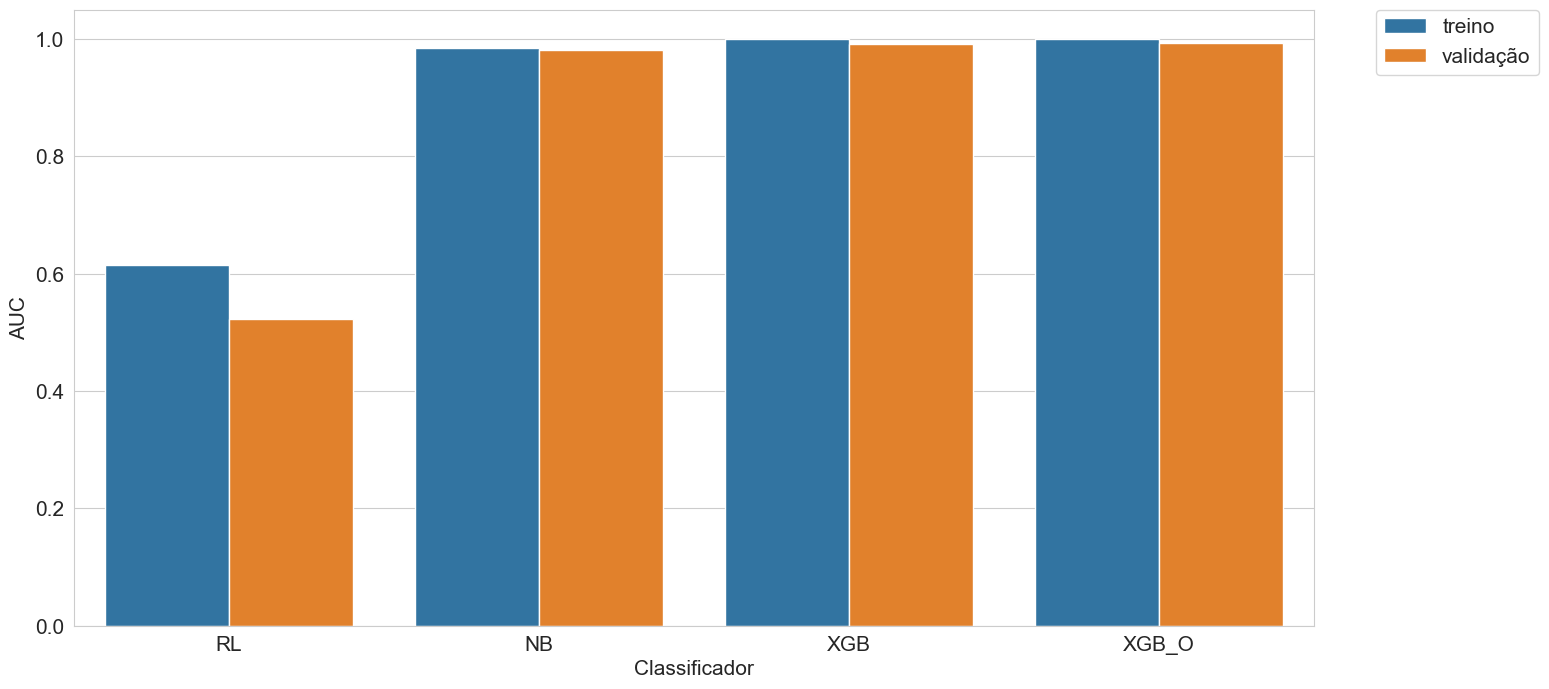

In [53]:
# Construção do Plot
sns.set_style("whitegrid")
plt.figure(figsize = (16, 8))

# Gráfico de barras
ax = sns.barplot(x = 'classificador', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classificador', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

# Legenda
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)
plt.show();

In [54]:
df_results

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RL,treino,0.615665,0.635935,0.519194,0.677340,0.752675
1,RL,validação,0.523291,0.680000,0.429730,0.318000,0.748339
2,NB,treino,0.984062,0.935494,0.898049,0.970748,0.972939
3,NB,validação,0.981912,0.957681,0.918919,0.887728,0.968266
4,XGB,treino,1.000000,1.000000,1.000000,1.000000,1.000000
5,XGB,validação,0.992209,0.959420,0.951351,0.871287,0.961624
6,XGB_O,treino,1.000000,1.000000,1.000000,1.000000,1.000000
7,XGB_O,validação,0.992501,0.965217,0.956757,0.889447,0.967528


In [55]:
# Tabela de comparação dos modelos somente com métricas em validação e ordenado por AUC
df_results[df_results['data_set'] == 'validação'].sort_values(by = 'auc', ascending = False)

,classificador,data_set,auc,accuracy,recall,precision,specificity
7,XGB_O,validação,0.992501,0.965217,0.956757,0.889447,0.967528
5,XGB,validação,0.992209,0.959420,0.951351,0.871287,0.961624
3,NB,validação,0.981912,0.957681,0.918919,0.887728,0.968266
1,RL,validação,0.523291,0.680000,0.429730,0.318000,0.748339


Considerando a métrica AUC, nosso melhor modelo é o Classificador XGBoost Versão Otimizada (versão 4). Essa será nossa escolha.

#### Gravando o Melhor Modelo

In [56]:
# Grava o modelo em disco
pickle.dump(modelo_v4, open('melhor_modelo_dsa.pkl', 'wb'), protocol = 4)

### Avaliação e Interpretação das Métricas

In [57]:
# Carrega o modelo, as colunas e o scaler
melhor_modelo = pickle.load(open('melhor_modelo_dsa.pkl','rb'))
cols_input = pickle.load(open('cols_input.sav','rb'))
scaler = pickle.load(open('scaler.sav', 'rb'))

# Carrega os dados
df_train = pd.read_csv('dados_treino.csv')
df_valid= pd.read_csv('dados_valid.csv')
df_test= pd.read_csv('dados_teste.csv')

# Cria matrizes x e y

# X
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

# Y
y_train = df_train['VARIAVEL_ALVO'].values
y_valid = df_valid['VARIAVEL_ALVO'].values
y_test = df_test['VARIAVEL_ALVO'].values

# Aplica a transformação nos dados
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

Calculando as previsões no formato de probabilidades.

In [58]:
# Calcula as probabilidades
y_train_preds = melhor_modelo.predict_proba(X_train_tf)[:,1]
y_valid_preds = melhor_modelo.predict_proba(X_valid_tf)[:,1]
y_test_preds = melhor_modelo.predict_proba(X_test_tf)[:,1]

Avaliação de desempenho.

In [60]:
thresh = 0.5

print('\nTreinamento:\n')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,
                                                                                               y_train_preds, 
                                                                                               thresh)

print('\nValidação:\n')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,
                                                                                               y_valid_preds, 
                                                                                               thresh)

print('\nTeste:\n')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,
                                                                                          y_test_preds, 
                                                                                          thresh)


Treinamento:

AUC:0.999
Acurácia:0.981
Recall:1.000
Precisão:0.911
Especificidade:0.976
 

Validação:

AUC:0.993
Acurácia:0.965
Recall:0.957
Precisão:0.889
Especificidade:0.968
 

Teste:

AUC:0.996
Acurácia:0.969
Recall:0.959
Precisão:0.893
Especificidade:0.972
 


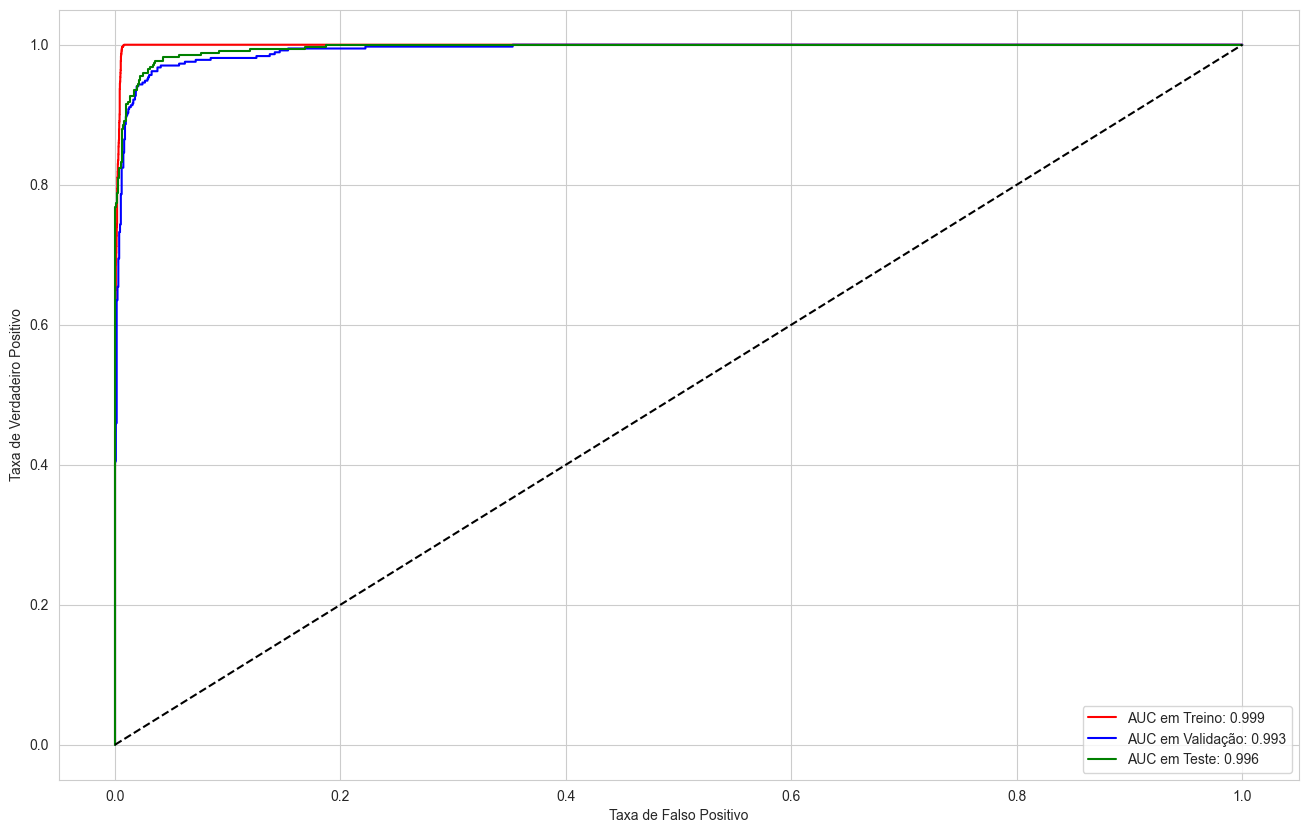

In [61]:
# Calcula a curva ROC nos dados de treino
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

# Calcula a curva ROC nos dados de validação
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

# Calcula a curva ROC nos dados de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

# Plot
plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-', label = 'AUC em Treino: %.3f' % auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label = 'AUC em Validação: %.3f' % auc_valid)
plt.plot(fpr_test, tpr_test, 'g-', label = 'AUC em Teste: %.3f' % auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.show()

## Deploy do Modelo e Uso com Novos Dados

In [62]:
# Carregando novos dados
nova_maquina = pd.read_csv('novos_dados.csv')

In [63]:
nova_maquina.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,51,43,34,21,13,12,6,4,1,-4,...,-41,-16,2,22,33,45,56,67,69,63


In [64]:
# Aplicamos a padronização aos novos dados de entrada
nova_maquina_scaled = scaler.transform(nova_maquina)

In [65]:
nova_maquina_scaled

array([[ 0.2643975 ,  0.22768402,  0.19409147,  0.13912449,  0.09401746,
         0.07303781,  0.03262827,  0.01993729,  0.00440827, -0.02114019,
        -0.06079783, -0.09054082, -0.10365275, -0.09978818, -0.08085062,
        -0.07125621, -0.07514578, -0.0809762 , -0.05821494, -0.04119012,
        -0.05083176, -0.02327228,  0.00483344,  0.01695165,  0.01114461,
         0.01348768,  0.03804561,  0.06194646,  0.08748316,  0.08013237,
         0.05846748,  0.0056553 , -0.00779099, -0.01909984,  0.01151312,
         0.0436982 ,  0.08611011,  0.12848219,  0.14700814,  0.18284997,
         0.19245727,  0.2064681 ,  0.19310842,  0.2068156 ,  0.2006546 ,
         0.19294124,  0.18169719,  0.14348007,  0.08619387,  0.04018069,
         0.02271856, -0.03883413, -0.09863939, -0.14930531, -0.18194282,
        -0.2040169 , -0.2094893 , -0.20821445, -0.19982783, -0.15939905,
        -0.1165332 , -0.073006  , -0.03371114, -0.05114636, -0.03987165,
        -0.03013024, -0.00930705,  0.04365018,  0.0

In [66]:
# Previsão de classe
melhor_modelo.predict(nova_maquina_scaled)

array([0])

### Conclusão do Projeto

Entregar o resultado de um projeto de Machine Learning envolve várias etapas que garantem que o modelo desenvolvido seja compreendido, avaliado e utilizado de maneira eficaz pelos stakeholders. Aqui estão os principais passos a serem considerados:

Documentação Completa: Inclua detalhes técnicos sobre como o modelo foi construído, os dados utilizados, a preparação dos dados, o algoritmo escolhido, os parâmetros ajustados e os resultados dos testes. Documente também qualquer pré-processamento de dados e escolhas de engenharia de atributos.

Avaliação do Modelo: Apresente uma avaliação detalhada do desempenho do modelo utilizando métricas relevantes (como precisão, recall, AUC-ROC, etc.). Use visualizações, como curvas ROC ou matrizes de confusão, para ilustrar os resultados de forma clara.

Relatório de Insights e Interpretações: Forneça insights sobre o que o modelo mostra, incluindo quais variáveis são mais importantes para as previsões e como as variáveis influenciam essas previsões. Ferramentas de interpretabilidade de modelo, como SHAP ou LIME, podem ser úteis aqui.

Demonstração Prática: Se possível, crie uma demonstração ou protótipo que mostre como o modelo funciona em um ambiente operacional. Isso pode ser uma aplicação web, um notebook Jupyter interativo ou até mesmo uma API que os stakeholders possam consultar para testar o modelo.

Manual do Usuário e Treinamento: Forneça um manual do usuário ou guias que expliquem como interagir com o modelo, incluindo como inserir dados, interpretar resultados e aplicar os resultados para tomada de decisão. Além disso, ofereça sessões de treinamento para os usuários finais que irão operar ou interagir regularmente com o modelo.

Plano de Implantação: Descreva como o modelo será implementado no ambiente de produção. Isso inclui detalhes técnicos sobre integração com sistemas existentes, requisitos de hardware/software e estratégias para atualizações e manutenção.

Plano de Monitoramento e Manutenção: Estabeleça um plano para monitorar o desempenho do modelo ao longo do tempo e identificar quando ele precisa ser recalibrado ou treinado com novos dados para manter sua precisão e relevância.

Feedback e Iteração: Inclua um mecanismo de feedback para coletar opiniões dos usuários sobre o desempenho do modelo e áreas para melhorias. Use essas informações para iterar sobre o modelo e melhorar continuamente sua precisão e usabilidade.

Projeto concluído, projeto entregue, cliente feliz, partimos para o próximo projeto!

In [67]:
%watermark -a "Marcelo Medeiros | Cientista de Dados"

Author: Marcelo Medeiros | Cientista de Dados



In [68]:
%watermark -v -m

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [69]:
%watermark --iversions

numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.7.2
xgboost   : 2.0.3
seaborn   : 0.12.2
sklearn   : 1.0.2



## FIM